**Purpose**

- Train a **smoother** model, test performance of our integration technique with different types of "kick" steps (euler, rk4)

- Our hope is that a smaller model will produce a smoother hamiltonian, and therefore error hamiltonian, making integration more reliable

**Update*
- ran models: no training, `.sum()`, `.sum()` + `scaled_H_std()` (amp = 1, smoothness error = 7, flatness error=1), `.std()`+ `scaled_H_std()` (amp = 2e3, smoothness error = flatness error = 1.4), `.std()` (just the post-training energy plot)


In [1]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits, scaled_H_std
from orbitflows.integrate import hamiltonian_fixed_angle, eulerstep
from orbitflows.integrate import rungekutta4 as rk4
from functools import partial 
import matplotlib.pyplot as plt
import numpy as np
import torch
from orbitflows import H
from time import time

In [2]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

In [3]:
def smoothing_term(ps, targetPotential):
    '''loss term that enforces smoothness by quantifying how much nearby points differ'''
    return torch.diff(H(ps, targetPotential), dim=-1).abs().std() + torch.diff(H(ps, targetPotential), dim=-1).abs().mean() 

In [4]:
def smooth_flat_H(ps, targetPotential, smoothing_amp=0.1):
    '''loss term that enforces smoothness by quantifying how much nearby points differ'''
    return (scaled_H_std(ps, targetPotential) + smoothing_amp * smoothing_term(ps, targetPotential))/100

# Setup and Training

In [5]:
# initialize model
model = HamiltonianMappingModel(targetPotential=isoDiskPotential, input_dim=2, hidden_dim=10, num_layers=4)
model.flow = model.flow.double()

In [6]:
model.flow

GsympNetFlow(
  (layers): ModuleList(
    (0-3): 4 x SymplecticCouplingLayer(
      (conditioner): GradientBasedConditioner()
    )
  )
  (conditioner): GradientBasedConditioner()
)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_6467/2701305543.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/native/TensorShape.cpp:3687.)
  plt.scatter(*training_data.T, s=10)



Text(0.5, 1.0, 'Toy Orbits')

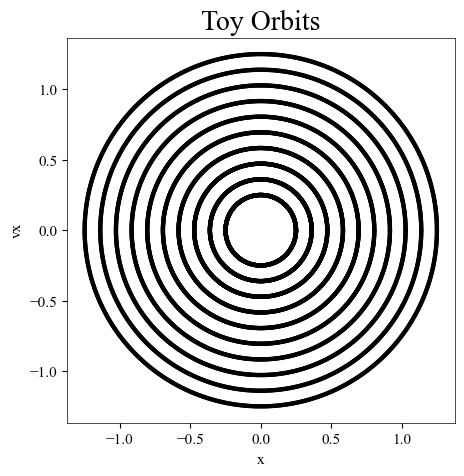

In [7]:
# create training set
n_actions = 10
n_angles = 1000
r_min = 0.25
r_max = 1.25
omega_guess = 1
training_data, aa_guess = generate_sho_orbits(n_actions, omega=omega_guess, t_end=2*np.pi, n_steps=n_angles, r_bounds=[r_min,r_max])
aa_guess = aa_guess.to(torch.float64)
training_data = training_data.to(torch.float64)

# plot training data
plt.figure(figsize=(5, 5))
plt.scatter(*training_data.T, s=10)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('vx')
plt.title('Toy Orbits', fontsize=20)

In [8]:
torch.diff(H(training_data, model.targetPotential), dim=-1).abs().mean()

tensor(0.0007, dtype=torch.float64)

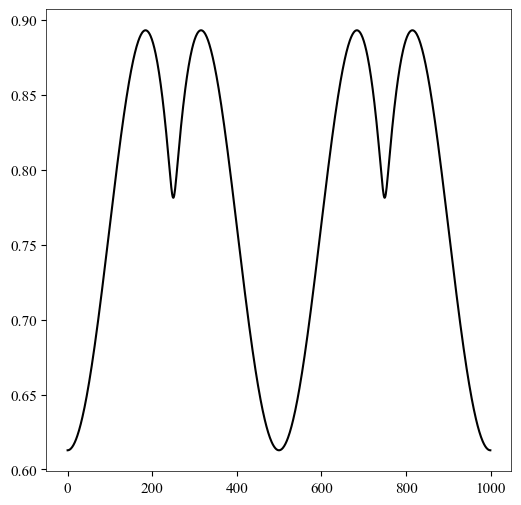

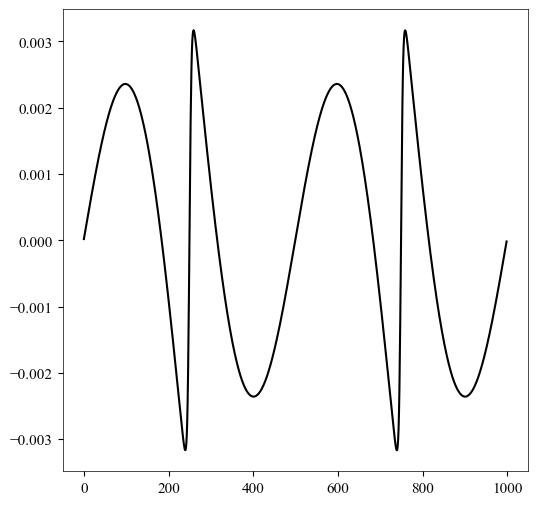

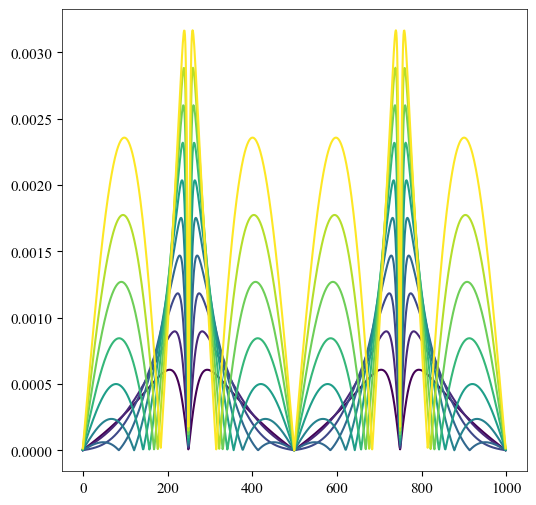

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(H(training_data, model.targetPotential)[-1])
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(torch.diff(H(training_data, model.targetPotential), dim=-1)[-1])
plt.show()

import matplotlib.cm as cm

plt.figure(figsize=(6, 6))
n_lines = torch.diff(H(training_data, model.targetPotential), dim=-1).abs().shape[0]
colors = cm.viridis(np.linspace(0.0, 1.0, n_lines))
for i, line in enumerate(torch.diff(H(training_data, model.targetPotential), dim=-1).abs()):
    plt.plot(line, color=colors[i])
plt.show()

In [10]:
scaled_H_std(training_data, model.targetPotential), smoothing_term(training_data, model.targetPotential)*1e3

(tensor(1.4052, dtype=torch.float64), tensor(1.4134, dtype=torch.float64))

In [11]:
# # train model
steps = 5000
model.train(training_data.to(torch.float64), steps, lr=1e-3, loss_function=smooth_flat_H, lf_args={'targetPotential': model.targetPotential, 'smoothing_amp':1.5e3})

# plot loss
plt.figure(figsize=(7, 5))
plt.loglog(model.loss_list)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title('Training Loss', fontsize=20)
plt.show()

# # plot performance for one orbit
# plt.figure(figsize=(8, 5))
# plt.plot(aa_guess[0][...,0].detach(), model.hamiltonian(aa_guess[0]).detach())
# plt.plot(aa_guess[0][...,0].detach(), np.repeat(model.hamiltonian(aa_guess[0]).mean().detach(), len(aa_guess[0][...,0].detach())), 'r--')
# plt.xlabel('time', fontsize=15)
# plt.ylabel('energy', fontsize=15)
# plt.title('model performance', fontsize=20)
# plt.show()

# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6, 6))
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), s=5, label='post-training')
plt.legend(markerscale=2, fontsize=15)
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)

  2%|▏         | 95/5000 [00:00<00:30, 159.58it/s]


KeyboardInterrupt: 

In [ ]:
# # # train model
# steps = 5000
# model.train(training_data.to(torch.float64), steps, lr=1e-3, loss_function=smooth_flat_H, lf_args={'targetPotential': model.targetPotential, 'smoothing_amp':1e3})

# # plot loss
# plt.figure(figsize=(7, 5))
# plt.loglog(model.loss_list)
# plt.xlabel('epochs', fontsize=15)
# plt.ylabel('loss', fontsize=15)
# plt.title('Training Loss', fontsize=20)
# plt.show()

# # # plot performance for one orbit
# # plt.figure(figsize=(8, 5))
# # plt.plot(aa_guess[0][...,0].detach(), model.hamiltonian(aa_guess[0]).detach())
# # plt.plot(aa_guess[0][...,0].detach(), np.repeat(model.hamiltonian(aa_guess[0]).mean().detach(), len(aa_guess[0][...,0].detach())), 'r--')
# # plt.xlabel('time', fontsize=15)
# # plt.ylabel('energy', fontsize=15)
# # plt.title('model performance', fontsize=20)
# # plt.show()

# # plot energy for transformed orbits (with NF) and without (pre-training)
# plt.figure(figsize=(6, 6))
# plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), s=5, label='pre-training')
# plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), s=5, label='post-training')
# plt.legend()
# plt.xlabel('angle', fontsize=15)
# plt.ylabel('energy', fontsize=15)

# Test Integrators

In [ ]:
# pick initial point for example orbit
aa0 = aa_guess[5][0].requires_grad_(True)
ps0 = model.aa_to_ps(aa0).requires_grad_(True)
H0 = H(ps0, model.targetPotential)

In [ ]:
# def h_averaged_angle(model, aa):
#     '''
#     Compute the Hamiltonian at an action, averaged over angles.
        
#     Parameters
#     ----------
#     aa : torch.tensor
#         action-angle variables

#     theta_set : torch.tensor
#         angle to be set in the Hamiltonian.
        
#     Returns
#     -------
#     torch.tensor
#         Hamiltonian averaged over the angle
#     '''
#     if len(aa.shape) == 1:
#         aa = aa.reshape(1, -1)
#     aa_list = torch.zeros((len(aa), 100, 2))
#     aa_list[..., 1] = aa[...,1].repeat(100).reshape(100, -1).T
#     aa_list[..., 0] = torch.linspace(0, 2 * np.pi, 100).repeat(len(aa)).reshape(100, -1).T
#     ham = model.hamiltonian(aa_list.to(torch.float64))
#     return torch.mean(ham, dim=-1)
#     #return model.hamiltonian(_aa)

In [ ]:
integration_steps = 20
t_end = 10
dt = t_end / integration_steps
st = time()
aa_euler_step = model.integrate(aa0, integration_steps, t_end, hamiltonian_tilde=hamiltonian_fixed_angle, correction=eulerstep).to(torch.float64)
euler_duration = time() - st

100%|██████████| 19/19 [00:00<00:00, 258.31it/s]


In [ ]:
rk4_steps = int(integration_steps)
st = time()
aa_rk4 = model.integrate(aa0, rk4_steps, t_end, correction=rk4, hamiltonian_tilde=hamiltonian_fixed_angle).to(torch.float64)
duration_rk4 = time() - st

100%|██████████| 19/19 [00:00<00:00, 75.48it/s]


<>:8: SyntaxWarning: invalid escape sequence '\s'

<>:9: SyntaxWarning: invalid escape sequence '\s'

<>:8: SyntaxWarning: invalid escape sequence '\s'

<>:9: SyntaxWarning: invalid escape sequence '\s'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_6363/2454499456.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(np.linspace(0, t_end, rk4_steps), model.hamiltonian(aa_rk4).detach(), label=f'rk4, dt={t_end/rk4_steps}, duration={duration_rk4:.2f}s, error={rk4_percent_error:.4f}%, $\sigma =$ {rk4_std:.2e}', alpha=0.75)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_6363/2454499456.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(np.linspace(0, t_end, integration_steps), model.hamiltonian(aa_euler_step).detach(), label=f'euler, dt={t_end/integration_steps}, duration={euler_duration:.2f}s, error={euler_percent_error:.4f}%, $\sigma =$ {euler_std:.2e}', alpha=0.75)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_6363/2454499456.py:2

Text(0, 0.5, 'energy')

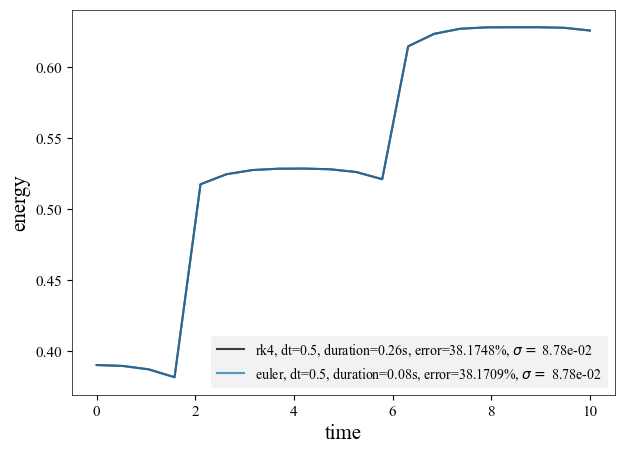

In [ ]:
# calculate error
euler_percent_error = np.mean(100 * (np.abs(model.hamiltonian(aa_euler_step).detach() - H0.detach()) /  H0.detach()).numpy())
euler_std = np.std(model.hamiltonian(aa_euler_step).detach().numpy())
rk4_percent_error = np.mean(100 * (np.abs(model.hamiltonian(aa_rk4).detach() - H0.detach()) /H0.detach()).numpy())
rk4_std = np.std(model.hamiltonian(aa_rk4).detach().numpy())

plt.figure(figsize=(7, 5))
plt.plot(np.linspace(0, t_end, rk4_steps), model.hamiltonian(aa_rk4).detach(), label=f'rk4, dt={t_end/rk4_steps}, duration={duration_rk4:.2f}s, error={rk4_percent_error:.4f}%, $\sigma =$ {rk4_std:.2e}', alpha=0.75)
plt.plot(np.linspace(0, t_end, integration_steps), model.hamiltonian(aa_euler_step).detach(), label=f'euler, dt={t_end/integration_steps}, duration={euler_duration:.2f}s, error={euler_percent_error:.4f}%, $\sigma =$ {euler_std:.2e}', alpha=0.75)
plt.legend(fontsize=10)
plt.xlabel('time', fontsize=15)
plt.ylabel('energy', fontsize=15)

### numerical integration

In [ ]:
from galpy.orbit import Orbit
from galpy.potential import IsothermalDiskPotential
o_lf = Orbit(ps0.detach().numpy())
st = time()
lf_steps = 40
o_lf.integrate(np.linspace(0, t_end, lf_steps), pot=IsothermalDiskPotential(), method='leapfrog')
duration_lf = time() - st

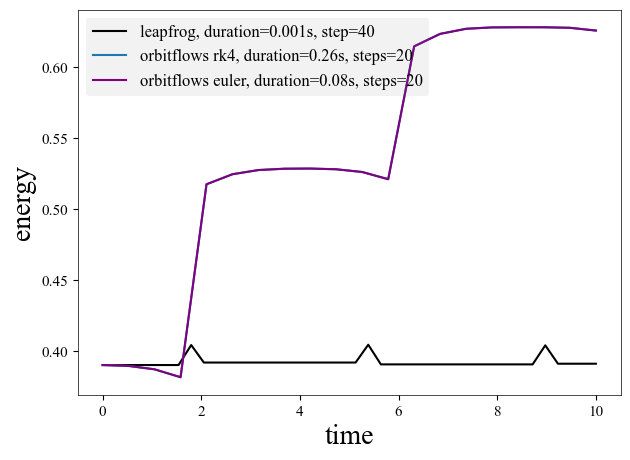

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(o_lf.time(), o_lf.E(o_lf.time()), label=f'leapfrog, duration={duration_lf:.3f}s, step={lf_steps}')
plt.plot(np.linspace(0, t_end, len(aa_rk4)), model.hamiltonian(aa_rk4).detach(
), label=f'orbitflows rk4, duration={duration_rk4:.2f}s, steps={rk4_steps}')
plt.plot(np.linspace(0, t_end, len(aa_euler_step)), model.hamiltonian(aa_euler_step).detach(
), label=f'orbitflows euler, duration={euler_duration:.2f}s, steps={integration_steps}', c='purple')
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend(fontsize=12)


# Assess Integration

In [ ]:
ps_start_training = model.aa_to_ps(aa_guess[:,0]).detach().numpy()
o_training = Orbit(ps_start_training)
st = time()
lf_steps = 1000
o_training.integrate(np.linspace(0, t_end, lf_steps), pot=IsothermalDiskPotential(), method='leapfrog')

## $\tilde{H}$ Plot

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_6363/3548670060.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_6363/3548670060.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()



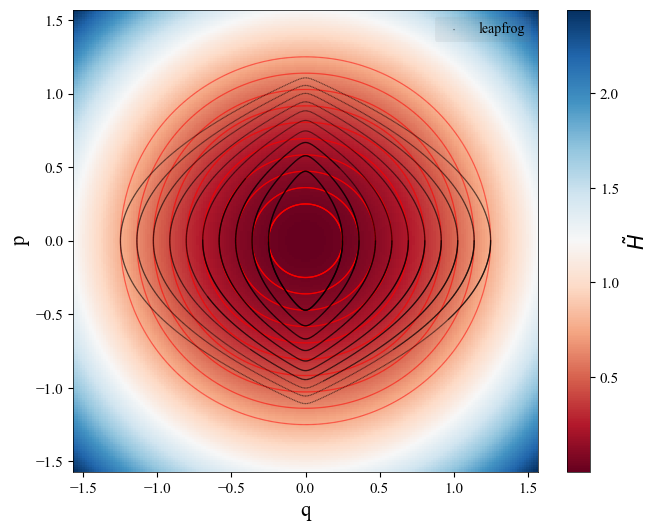

In [ ]:
# Determine the range for q (x) and p (vx) from training data
scaling = 1.25
x_min, x_max = training_data[..., 0].min().item() * scaling, training_data[..., 0].max().item() * scaling
vx_min, vx_max = training_data[..., 1].min().item() * scaling, training_data[..., 1].max().item() * scaling

# Create a grid of points in phase space
n_grid_points = 200 # Number of points for each dimension in the grid
x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()
vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()
x_grid = torch.linspace(-x_minmax, x_minmax, n_grid_points)
vx_grid = torch.linspace(-vx_minmax, vx_minmax, n_grid_points)
X, VX = torch.meshgrid(x_grid, vx_grid, indexing='xy')

# Prepare phase-space points for h_error function
ps_grid = torch.stack([X.flatten(), VX.flatten()], dim=1)

# Calculate h_error for each point in the grid
h_tilde_values = torch.zeros(ps_grid.shape[0])

with torch.no_grad(): # No need to track gradients for plotting
    h_tilde_values = hamiltonian_fixed_angle(model, model.ps_to_aa(ps_grid.to(torch.float64)))

# Reshape error_values to the grid shape
h_tilde_grid = h_tilde_values.reshape(n_grid_points, n_grid_points)

# Plot the colormap
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(X.numpy(), VX.numpy(), h_tilde_grid.numpy(), cmap='RdBu', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('$\\tilde{H}$', fontsize=15)

plt.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(), model.aa_to_ps(aa_guess)[..., 1].detach().numpy(), c='r', alpha=0.5, s=1)
plt.scatter(o_training.x(o_training.time()), o_training.vx(o_training.time()), c='k', alpha=0.5, s=1, label='leapfrog')
plt.legend(fontsize=10)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
plt.show()

## $H_{\text{error}}$ Plot

In [ ]:
def h_error(model, ps):
    '''
    Compute the error of the model prediction in the Hamiltonian.
    
    Parameters
    ----------
    ps : torch.tensor
        phase-space point
    
    Returns
    -------
    torch.tensor
        Hamiltonian error of the model prediction
    '''
    _aa = model.ps_to_aa(ps)
    return H(ps, model.targetPotential) - hamiltonian_fixed_angle(model, _aa)

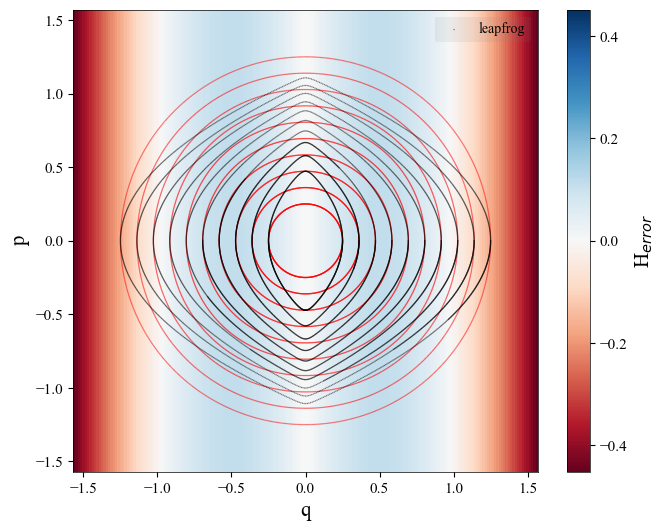

In [ ]:
# Calculate h_error for each point in the grid
error_values = torch.zeros(ps_grid.shape[0])

with torch.no_grad(): # No need to track gradients for plotting
    error_values = h_error(model, ps_grid.to(torch.float64))

# Reshape error_values to the grid shape
error_grid = error_values.reshape(n_grid_points, n_grid_points)

# Plot the colormap
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(X.numpy(), VX.numpy(), error_grid.numpy(), cmap='RdBu', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('H$_{error}$', fontsize=15)
pcm.set_clim(vmin=error_grid.min().item(), vmax=-error_grid.min().item())

plt.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(), model.aa_to_ps(aa_guess)[..., 1].detach().numpy(), c='r', alpha=0.5, s=1)
plt.scatter(o_training.x(o_training.time()), o_training.vx(o_training.time()), c='k', alpha=0.5, s=1, label='leapfrog')
plt.legend(fontsize=10)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
plt.show()

In [ ]:
def freq_tilde(model, aa):
    '''
    Compute the frequency of the system using the hamiltonian_tilde function.
    
    Parameters
    ----------
    aa : torch.tensor

            action-angle variables

    Returns
    -------
    torch.tensor
        frequency of the system assuming the hamiltonian_tilde function
    '''
    theta, j = aa[..., 0], aa[..., 1]
    _aa = torch.stack((theta, j), dim=-1)
    return torch.autograd.grad(hamiltonian_fixed_angle(model, _aa), j, allow_unused=True)[0]#hamiltonian_fixed_angle(model, _aa), j, allow_unused=True)[0]

In [ ]:
from orbitflows.integrate.correction import dH_dx
from tqdm import tqdm

## Partial Derivates of $H_{\text{error}}$

In [ ]:
# calculate partial derivatives over a grid in phase space
scaling = 1.25
x_min, x_max = training_data[..., 0].min().item() * scaling, training_data[..., 0].max().item() * scaling
vx_min, vx_max = training_data[..., 1].min().item() * scaling, training_data[..., 1].max().item() * scaling

# Create a grid of points in phase space
n_grid_points = 50 # Number of points for each dimension in the grid
x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()
vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()
x_grid = torch.linspace(-x_minmax, x_minmax, n_grid_points)
vx_grid = torch.linspace(-vx_minmax, vx_minmax, n_grid_points)
X, VX = torch.meshgrid(x_grid, vx_grid, indexing='xy')
ps_grid = torch.stack([X.flatten(), VX.flatten()], dim=1).to(torch.float64)

dH_dq_grid = []
dH_dp_grid = []
for ps_ in tqdm(ps_grid.requires_grad_()):
    dH_dq_grid.append(dH_dx(ps_, 'q', partial(h_error, model)))
    dH_dp_grid.append(dH_dx(ps_, 'p', partial(h_error, model)))


/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_6363/3237592667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_6363/3237592667.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()



 52%|█████▏    | 1302/2500 [00:03<00:03, 381.14it/s]


KeyboardInterrupt: 

In [ ]:
# Reshape error_values to the grid shape
dH_dq_grid = torch.tensor(dH_dq_grid).reshape(n_grid_points, n_grid_points)
dH_dp_grid = torch.tensor(dH_dp_grid).reshape(n_grid_points, n_grid_points)

In [ ]:
def partials_plot(
        aa,
        stepfunct,
        aa_guess,
        model,
        dH_dq_grid,
        dH_dp_grid,
        freq_tilde,
        training_orbits_correct = True,
        training_orbits_approx = True,
        quivers = True,
        title=''
        ):
        '''
        Plot the partial derivatives of the Hamiltonian error with respect to q and p.
        '''
        fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, gridspec_kw={'hspace': 0.05, 'wspace': 0.075})
        pcm = ax[0].pcolormesh(X.numpy(), VX.numpy(), dH_dq_grid.numpy(), cmap='RdBu', shading='auto')
        pcm2 = ax[1].pcolormesh(X.numpy(), VX.numpy(), dH_dp_grid.numpy(), cmap='RdBu', shading='auto')

        ax[0].set_title('$- \\frac{\partial{H_{error}}(q,p)}{\partial q}$', fontsize=20)
        ax[1].set_title('$\\frac{\partial{H_{error}}(q,p)}{\partial p}$', fontsize=20)

        cax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
        plt.colorbar(pcm, cax=cax)
        minmax = torch.abs(torch.tensor([dH_dq_grid.max().item(), dH_dq_grid.min().item(), dH_dp_grid.max().item(), dH_dp_grid.min().item()])).max().item()
        pcm.set_clim(vmin=-minmax, vmax=minmax)
        pcm2.set_clim(vmin=-minmax, vmax=minmax)
        aa0 = aa[0].requires_grad_(True)

        if quivers:
                # drift 1 arrow
                freq_tildes = torch.tensor([freq_tilde(model, aa_) for aa_ in aa]).to(torch.float64) # Shape (n_steps, 2)
                aa_orb_guess = aa.clone().detach() # Shape (n_steps, 2)
                aa_orb_guess[...,0] = aa[..., 0] +  torch.tensor(freq_tildes) * dt/2
                nf_prediction_ps = model.aa_to_ps(aa_orb_guess.to(torch.float64)) # Shape (n_steps, 2)
                qp_quiver = model.aa_to_ps(aa)
                q_plot_quiver = qp_quiver[..., 0]
                p_plot_quiver = qp_quiver[..., 1]
                delta_q_guess = nf_prediction_ps[..., 0] - q_plot_quiver
                delta_p_guess = nf_prediction_ps[..., 1] - p_plot_quiver

                # kick arrow
                q_plot_quiver_2 = []
                p_plot_quiver_2 = []
                delta_q_guess_2 = []
                delta_p_guess_2 = []
                for i, qp in enumerate(nf_prediction_ps):
                        new_ps = stepfunct(qp, dt, partial(h_error, model))
                        q_plot_quiver_2.append(new_ps[0].detach().item())
                        p_plot_quiver_2.append(new_ps[1].detach().item())
                        delta_q_guess_2.append((new_ps[0] - qp[0]).detach()) #nf_prediction_ps[..., 0] - q_plot_quiver_2
                        delta_p_guess_2.append((new_ps[1] - qp[1]).detach()) # nf_prediction_ps[..., 1] - p_plot_quiver_2

                q_plot_quiver_2 = torch.tensor(q_plot_quiver_2).to(torch.float64)
                p_plot_quiver_2 = torch.tensor(p_plot_quiver_2).to(torch.float64)


                # drift 2 arrow
                new_aa = model.ps_to_aa(torch.stack((q_plot_quiver_2, p_plot_quiver_2), dim=-1))
                new_freq_tildes = torch.tensor([freq_tilde(model, aa_) for aa_ in new_aa]).to(torch.float64)
                drift_2_aa = new_aa.clone().detach()
                drift_2_aa[..., 0] = new_aa[..., 0] +  torch.tensor(new_freq_tildes) * dt/2
                drift_2_ps = model.aa_to_ps(drift_2_aa.to(torch.float64))
                delta_q_guess_drift2 = drift_2_ps[..., 0] -  q_plot_quiver_2
                delta_p_guess_drift2 = drift_2_ps[..., 1] - p_plot_quiver_2

        ex_orb = aa0.repeat(len(aa_guess[0][...,0]), 1)
        ex_orb[...,0] = aa_guess[0][...,0].detach()

        for axi in ax:
                if training_orbits_correct:
                        axi.scatter(o_training.x(o_training.time()), o_training.vx(o_training.time()), c='k', s=1, alpha=0.25)
                        axi.scatter(o_training.x(o_training.time())[5], o_training.vx(o_training.time())[5], c='teal', s=3, alpha=1)
                if training_orbits_approx:
                        axi.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(),
                                model.aa_to_ps(aa_guess)[..., 1].detach().numpy(),
                                c='r', alpha=0.25, s=1)
                        axi.plot(*model.aa_to_ps(aa).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, integrated with flow (rk4)', lw=1)
                        axi.scatter(*model.aa_to_ps(aa).T.detach().numpy(), c='b', alpha=0.75, s=20)
                if quivers:
                        # arrows
                        axi.quiver(q_plot_quiver[:-1].detach().numpy(), p_plot_quiver[:-1].detach().numpy(),
                                delta_q_guess.detach().numpy()[:-1], delta_p_guess.detach().numpy()[:-1],
                                angles='xy', scale_units='xy', scale=1, color='k', width=0.005, alpha=1,
                                label=f'drift')
                        axi.quiver(nf_prediction_ps[..., 0][:-1].detach().numpy(), nf_prediction_ps[..., 1][:-1].detach().numpy(),
                                delta_q_guess_2[:-1], delta_p_guess_2[:-1],
                                angles='xy', scale_units='xy', scale=1, color='r', width=0.005, alpha=1,
                                label=f'kick')
                        axi.quiver(q_plot_quiver_2[:-1].detach().numpy(), p_plot_quiver_2[:-1].detach().numpy(),
                                delta_q_guess_drift2.detach().numpy()[:-1], delta_p_guess_drift2.detach().numpy()[:-1],
                                angles='xy', scale_units='xy', scale=1, color='k', width=0.005, alpha=1,
                                label=f'drift')
        
        
                axi.scatter(*ps0.detach(), c='cyan')

        ax[1].annotate('q', xy=(-0.04, -0.15), xycoords='axes fraction', ha='center', fontsize=20)
        ax[0].annotate('p', xy=(-0.15, 0.5), xycoords='axes fraction', ha='center', fontsize=20, rotation='vertical')
        ax[0].set_xlim(-1.5, 1.5)
        ax[0].set_ylim(-1.5, 1.5)
        ax[1].legend(fontsize=10, loc='upper right')
        ax[1].annotate(title, xy=(-0.04, 1.2), xycoords='axes fraction', ha='center', fontsize=20)

        return fig, ax

<>:21: SyntaxWarning: invalid escape sequence '\p'

<>:22: SyntaxWarning: invalid escape sequence '\p'

<>:21: SyntaxWarning: invalid escape sequence '\p'

<>:22: SyntaxWarning: invalid escape sequence '\p'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_7959/1407300018.py:21: SyntaxWarning: invalid escape sequence '\p'
  ax[0].set_title('$- \\frac{\partial{H_{error}}(q,p)}{\partial q}$', fontsize=20)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_7959/1407300018.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax[1].set_title('$\\frac{\partial{H_{error}}(q,p)}{\partial p}$', fontsize=20)



/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_7959/1407300018.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa_orb_guess[...,0] = aa[..., 0] +  torch.tensor(freq_tildes) * dt/2

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_7959/1407300018.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drift_2_aa[..., 0] = new_aa[..., 0] +  torch.tensor(new_freq_tildes) * dt/2



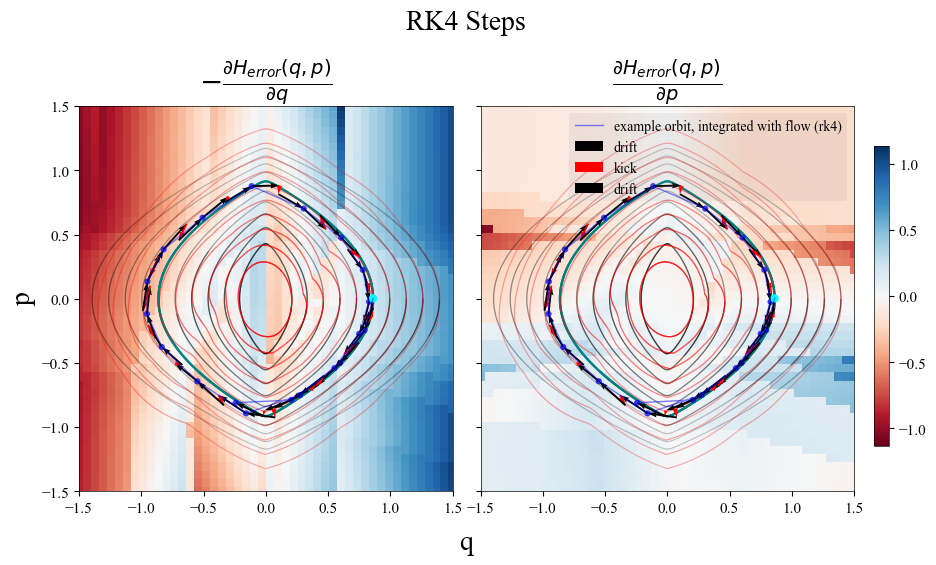

In [ ]:
fig_rk4, ax_rk4 = partials_plot(aa_rk4, rk4, aa_guess, model, dH_dq_grid, dH_dp_grid, freq_tilde, title='RK4 Steps')

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_7959/1407300018.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa_orb_guess[...,0] = aa[..., 0] +  torch.tensor(freq_tildes) * dt/2

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_7959/1407300018.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drift_2_aa[..., 0] = new_aa[..., 0] +  torch.tensor(new_freq_tildes) * dt/2



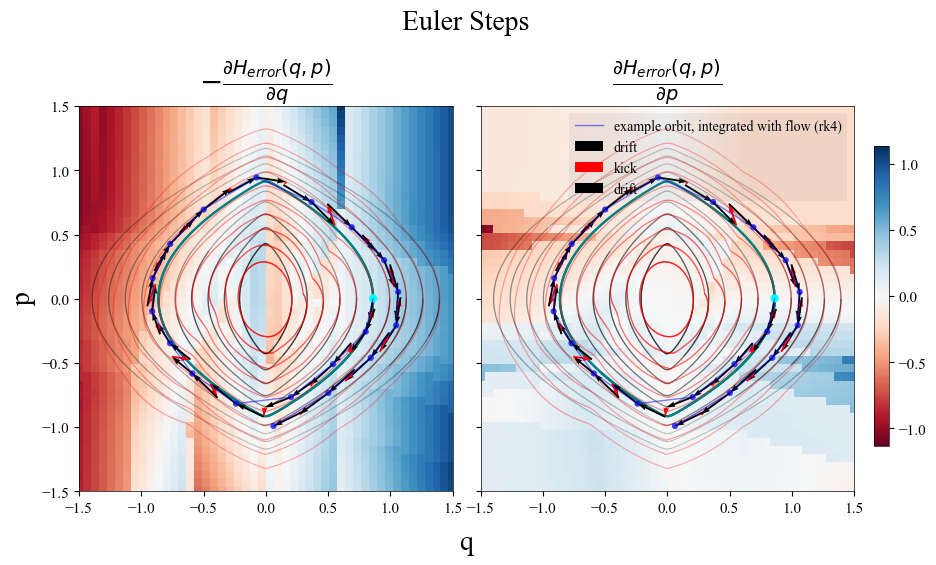

In [ ]:
fig_euler, ax_euler = partials_plot(aa_euler_step, eulerstep, aa_guess, model, dH_dq_grid, dH_dp_grid, freq_tilde, title='Euler Steps')

## Varying step sizes

In [ ]:
# # Define different step sizes to test
# step_sizes = [5, 10, 20, 40, 80, 160] #[20, 21, 22, 23, 24, 25]
# t_end_test = 100

# # Store results for each step size
# results = {}

# for steps in step_sizes:
#     print(f"Running integration with {steps} steps...")
#     dt_test = t_end_test / steps
    
#     # Euler integration
#     st = time()
#     aa_euler = model.integrate(aa0, steps, t_end_test, hamiltonian_tilde=hamiltonian_fixed_angle, correction=eulerstep).to(torch.float64)
#     euler_time = time() - st
    
#     # RK4 integration
#     st = time()
#     aa_rk4_test = model.integrate(aa0, steps, t_end_test, correction=rk4, hamiltonian_tilde=hamiltonian_fixed_angle).to(torch.float64)
#     rk4_time = time() - st
    
#     # Calculate errors
#     euler_error = np.max((np.abs(model.hamiltonian(aa_euler).detach() - H0.detach()) / H0.detach()).numpy())
#     euler_std_test = np.std(model.hamiltonian(aa_euler).detach().numpy())
#     rk4_error = np.max((np.abs(model.hamiltonian(aa_rk4_test).detach() - H0.detach()) / H0.detach()).numpy())
#     rk4_std_test = np.std(model.hamiltonian(aa_rk4_test).detach().numpy())
    
#     results[steps] = {
#         'euler': {'aa': aa_euler, 'time': euler_time, 'error': euler_error, 'std': euler_std_test},
#         'rk4': {'aa': aa_rk4_test, 'time': rk4_time, 'error': rk4_error, 'std': rk4_std_test},
#         'dt': dt_test
#     }
    
# print("Integration complete!")

In [ ]:
# # Create grid plot
# fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# axes = axes.flatten()

# for i, steps in enumerate(step_sizes):
#     ax = axes[i]
#     result = results[steps]
    
#     # Plot RK4 results
#     time_array = np.linspace(0, t_end_test, steps)
#     ax.plot(time_array, model.hamiltonian(result['rk4']['aa']).detach(), 
#             label=f'RK4: error={result["rk4"]["error"]:.2f}%, σ={result["rk4"]["std"]:.2e}', 
#             alpha=0.75, linewidth=2)
    
#     # Plot Euler results
#     ax.plot(time_array, model.hamiltonian(result['euler']['aa']).detach(), 
#             label=f'Euler: error={result["euler"]["error"]:.2f}%, σ={result["euler"]["std"]:.2e}', 
#             alpha=0.75, linewidth=2)
    
#     # Add horizontal line at initial energy
#     ax.axhline(y=H0.detach(), color='black', linestyle='--', alpha=0.5, label='Initial Energy')
    
#     ax.set_title(f'{steps} steps (dt={result["dt"]:.3f})', fontsize=14)
#     ax.legend(fontsize=8)
#     ax.grid(True, alpha=0.3)

# # Set common labels
# fig.text(0.5, 0.04, 'Time', ha='center', fontsize=16)
# fig.text(0.04, 0.5, 'Energy', va='center', rotation='vertical', fontsize=16)
# fig.suptitle('Energy Conservation Comparison: Well Trained Model', fontsize=18)

# plt.tight_layout()
# plt.subplots_adjust(bottom=0.1, left=0.1)
# plt.show()

In [ ]:
# # Summary table of results
# import pandas as pd

# summary_data = []
# for steps in step_sizes:
#     result = results[steps]
#     summary_data.append({
#         'Steps': steps,
#         'dt': result['dt'],
#         'Euler Error (%)': result['euler']['error'],
#         'Euler σ': result['euler']['std'],
#         'Euler Time (s)': result['euler']['time'],
#         'RK4 Error (%)': result['rk4']['error'],
#         'RK4 σ': result['rk4']['std'],
#         'RK4 Time (s)': result['rk4']['time']
#     })

# summary_df = pd.DataFrame(summary_data)
# print("Summary of Integration Results:")
# print(summary_df.to_string(index=False, float_format='%.4f'))

In [ ]:
# # Plot error vs step size
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# # Error vs step size
# ax1.loglog([results[s]['dt'] for s in step_sizes], [results[s]['euler']['error'] for s in step_sizes], 
#           'o-', label='Euler', linewidth=2, markersize=8)
# ax1.loglog([results[s]['dt'] for s in step_sizes], [results[s]['rk4']['error'] for s in step_sizes], 
#           's-', label='RK4', linewidth=2, markersize=8)
# ax1.set_xlabel('Step size (dt)', fontsize=14)
# ax1.set_ylabel('$\\text{log}_{10}(\\text{max}(\\frac{|\Delta H|}{H}))$', fontsize=14)
# ax1.set_title('Error vs Step Size', fontsize=16)
# ax1.legend(fontsize=12)
# ax1.grid(True, alpha=0.3)

# # Standard deviation vs step size
# ax2.loglog([results[s]['dt'] for s in step_sizes], [results[s]['euler']['std'] for s in step_sizes], 
#           'o-', label='Euler', linewidth=2, markersize=8)
# ax2.loglog([results[s]['dt'] for s in step_sizes], [results[s]['rk4']['std'] for s in step_sizes], 
#           's-', label='RK4', linewidth=2, markersize=8)
# ax2.set_xlabel('Step size (dt)', fontsize=14)
# ax2.set_ylabel('Energy Standard Deviation', fontsize=14)
# ax2.set_title('Energy Fluctuations vs Step Size', fontsize=16)
# ax2.legend(fontsize=12)
# ax2.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

### Fine-grained step size comparison (20-25 steps)

In [ ]:
# # Define fine-grained step sizes to test sensitivity
# fine_step_sizes = [20, 21, 22, 23, 24, 25]
# t_end_fine = 100

# # Store results for each step size
# fine_results = {}

# for steps in fine_step_sizes:
#     print(f"Running integration with {steps} steps...")
#     dt_fine = t_end_fine / steps
    
#     # Euler integration
#     st = time()
#     aa_euler_fine = model.integrate(aa0, steps, t_end_fine, hamiltonian_tilde=hamiltonian_fixed_angle, correction=eulerstep).to(torch.float64)
#     euler_time_fine = time() - st
    
#     # RK4 integration
#     st = time()
#     aa_rk4_fine = model.integrate(aa0, steps, t_end_fine, correction=rk4, hamiltonian_tilde=hamiltonian_fixed_angle).to(torch.float64)
#     rk4_time_fine = time() - st
    
#     # Calculate errors
#     euler_error_fine = np.max((np.abs(model.hamiltonian(aa_euler_fine).detach() - H0.detach()) / H0.detach()).numpy())
#     euler_std_fine = np.std(model.hamiltonian(aa_euler_fine).detach().numpy())
#     rk4_error_fine = np.max((np.abs(model.hamiltonian(aa_rk4_fine).detach() - H0.detach()) / H0.detach()).numpy())
#     rk4_std_fine = np.std(model.hamiltonian(aa_rk4_fine).detach().numpy())
    
#     fine_results[steps] = {
#         'euler': {'aa': aa_euler_fine, 'time': euler_time_fine, 'error': euler_error_fine, 'std': euler_std_fine},
#         'rk4': {'aa': aa_rk4_fine, 'time': rk4_time_fine, 'error': rk4_error_fine, 'std': rk4_std_fine},
#         'dt': dt_fine
#     }
    
# print("Fine-grained integration complete!")

In [ ]:
# # Create fine-grained grid plot
# fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# axes = axes.flatten()

# for i, steps in enumerate(fine_step_sizes):
#     ax = axes[i]
#     result = fine_results[steps]
    
#     # Plot RK4 results
#     time_array = np.linspace(0, t_end_fine, steps)
#     ax.plot(time_array, model.hamiltonian(result['rk4']['aa']).detach(), 
#             label=f'RK4: error={result["rk4"]["error"]:.3f}%, σ={result["rk4"]["std"]:.2e}', 
#             alpha=0.75, linewidth=2)
    
#     # Plot Euler results
#     ax.plot(time_array, model.hamiltonian(result['euler']['aa']).detach(), 
#             label=f'Euler: error={result["euler"]["error"]:.3f}%, σ={result["euler"]["std"]:.2e}', 
#             alpha=0.75, linewidth=2)
    
#     # Add horizontal line at initial energy
#     ax.axhline(y=H0.detach(), color='black', linestyle='--', alpha=0.5, label='Initial Energy')
    
#     ax.set_title(f'{steps} steps (dt={result["dt"]:.4f})', fontsize=14)
#     ax.legend(fontsize=8)
#     ax.grid(True, alpha=0.3)

# # Set common labels
# fig.text(0.5, 0.04, 'Time', ha='center', fontsize=16)
# fig.text(0.04, 0.5, 'Energy', va='center', rotation='vertical', fontsize=16)
# fig.suptitle('Fine-Grained Energy Conservation Comparison (20-25 steps)', fontsize=18)

# plt.tight_layout()
# plt.subplots_adjust(bottom=0.1, left=0.1)
# plt.show()

In [ ]:
# # Fine-grained summary table
# fine_summary_data = []
# for steps in fine_step_sizes:
#     result = fine_results[steps]
#     fine_summary_data.append({
#         'Steps': steps,
#         'dt': result['dt'],
#         'Euler Error (%)': result['euler']['error'],
#         'Euler σ': result['euler']['std'],
#         'Euler Time (s)': result['euler']['time'],
#         'RK4 Error (%)': result['rk4']['error'],
#         'RK4 σ': result['rk4']['std'],
#         'RK4 Time (s)': result['rk4']['time']
#     })

# fine_summary_df = pd.DataFrame(fine_summary_data)
# print("Fine-Grained Integration Results Summary:")
# print(fine_summary_df.to_string(index=False, float_format='%.5f'))

In [ ]:
# # Combined comparison plot showing both coarse and fine-grained results
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Plot 1: Error vs step size (both datasets)
# # Original coarse data
# ax1.loglog([results[s]['dt'] for s in step_sizes], [results[s]['euler']['error'] for s in step_sizes], 
#           'o-', label='Euler (coarse)', linewidth=2, markersize=8, alpha=0.7)
# ax1.loglog([results[s]['dt'] for s in step_sizes], [results[s]['rk4']['error'] for s in step_sizes], 
#           's-', label='RK4 (coarse)', linewidth=2, markersize=8, alpha=0.7)

# # Fine-grained data
# ax1.loglog([fine_results[s]['dt'] for s in fine_step_sizes], [fine_results[s]['euler']['error'] for s in fine_step_sizes], 
#           'o-', label='Euler (fine)', linewidth=2, markersize=6, color='red')
# ax1.loglog([fine_results[s]['dt'] for s in fine_step_sizes], [fine_results[s]['rk4']['error'] for s in fine_step_sizes], 
#           's-', label='RK4 (fine)', linewidth=2, markersize=6, color='blue')

# ax1.set_xlabel('Step size (dt)', fontsize=14)
# ax1.set_ylabel('Mean Error (%)', fontsize=14)
# ax1.set_title('Error vs Step Size: Combined View', fontsize=16)
# ax1.legend(fontsize=10)
# ax1.grid(True, alpha=0.3)

# # Plot 2: Linear scale focusing on fine-grained region
# ax2.plot([fine_results[s]['dt'] for s in fine_step_sizes], [fine_results[s]['euler']['error'] for s in fine_step_sizes], 
#          'o-', label='Euler', linewidth=2, markersize=8, color='red')
# ax2.plot([fine_results[s]['dt'] for s in fine_step_sizes], [fine_results[s]['rk4']['error'] for s in fine_step_sizes], 
#          's-', label='RK4', linewidth=2, markersize=8, color='blue')

# ax2.set_xlabel('Step size (dt)', fontsize=14)
# ax2.set_ylabel('Mean Error (%)', fontsize=14)
# ax2.set_title('Error Sensitivity (20-25 steps, linear scale)', fontsize=16)
# ax2.legend(fontsize=12)
# ax2.grid(True, alpha=0.3)

# # Add step count annotations
# for i, steps in enumerate(fine_step_sizes):
#     dt_val = fine_results[steps]['dt']
#     euler_err = fine_results[steps]['euler']['error']
#     rk4_err = fine_results[steps]['rk4']['error']
#     ax2.annotate(f'{steps}', (dt_val, euler_err), xytext=(5, 5), 
#                 textcoords='offset points', fontsize=8, alpha=0.7)
#     ax2.annotate(f'{steps}', (dt_val, rk4_err), xytext=(5, -10), 
#                 textcoords='offset points', fontsize=8, alpha=0.7)

# plt.tight_layout()
# plt.show()

In [ ]:
# # Difference analysis between consecutive step sizes
# print("Error differences between consecutive step sizes:")
# print("="*60)

# for i in range(len(fine_step_sizes) - 1):
#     curr_steps = fine_step_sizes[i]
#     next_steps = fine_step_sizes[i + 1]
    
#     curr_euler = fine_results[curr_steps]['euler']['error']
#     next_euler = fine_results[next_steps]['euler']['error']
#     euler_diff = next_euler - curr_euler
    
#     curr_rk4 = fine_results[curr_steps]['rk4']['error']
#     next_rk4 = fine_results[next_steps]['rk4']['error']
#     rk4_diff = next_rk4 - curr_rk4
    
#     print(f"Steps {curr_steps} → {next_steps}:")
#     print(f"  Euler error change: {euler_diff:+.4f}% ({curr_euler:.4f}% → {next_euler:.4f}%)")
#     print(f"  RK4 error change:   {rk4_diff:+.4f}% ({curr_rk4:.4f}% → {next_rk4:.4f}%)")
#     print()

In [ ]:
# Define fine-grained step sizes to test sensitivity
fine_step_sizes = np.arange(5, 100, 5) * 5
t_end_fine = 10 * 5

# Store results for each step size
fine_results = {}

for steps in fine_step_sizes:
    print(f"Running integration with {steps} steps...")
    dt_fine = t_end_fine / steps
    
    # Euler integration
    st = time()
    aa_euler_fine = model.integrate(aa0, steps, t_end_fine, hamiltonian_tilde=hamiltonian_fixed_angle, correction=eulerstep).to(torch.float64)
    euler_time_fine = time() - st
    
    # RK4 integration
    st = time()
    aa_rk4_fine = model.integrate(aa0, steps, t_end_fine, correction=rk4, hamiltonian_tilde=hamiltonian_fixed_angle).to(torch.float64)
    rk4_time_fine = time() - st
    
    # Calculate errors
    euler_error_fine = np.max((np.abs(model.hamiltonian(aa_euler_fine).detach() - H0.detach()) / H0.detach()).numpy())
    euler_std_fine = np.std(model.hamiltonian(aa_euler_fine).detach().numpy())
    rk4_error_fine = np.max((np.abs(model.hamiltonian(aa_rk4_fine).detach() - H0.detach()) / H0.detach()).numpy())
    rk4_std_fine = np.std(model.hamiltonian(aa_rk4_fine).detach().numpy())
    
    fine_results[steps] = {
        'euler': {'aa': aa_euler_fine, 'time': euler_time_fine, 'error': euler_error_fine, 'std': euler_std_fine},
        'rk4': {'aa': aa_rk4_fine, 'time': rk4_time_fine, 'error': rk4_error_fine, 'std': rk4_std_fine},
        'dt': dt_fine
    }
    
print("Fine-grained integration complete!")

Running integration with 25 steps...


100%|██████████| 24/24 [00:00<00:00, 83.45it/s]


/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_7959/448831656.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  euler_error_fine = np.max((np.abs(model.hamiltonian(aa_euler_fine).detach() - H0.detach()) / H0.detach()).numpy())

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_7959/448831656.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rk4_error_fine = np.max((np.abs(model.hamiltonian(aa_rk4_fine).detach() - H0.detach()) / H0.detach()).numpy())

Running integration with 50 steps...


100%|██████████| 49/49 [00:00<00:00, 82.44it/s]


Running integration with 75 steps...


100%|██████████| 74/74 [00:00<00:00, 75.05it/s]


Running integration with 100 steps...


100%|██████████| 99/99 [00:01<00:00, 80.10it/s]


Running integration with 125 steps...


100%|██████████| 124/124 [00:01<00:00, 80.10it/s]


Running integration with 150 steps...


100%|██████████| 149/149 [00:01<00:00, 78.69it/s]


Running integration with 175 steps...


100%|██████████| 174/174 [00:02<00:00, 82.65it/s]


Running integration with 200 steps...


100%|██████████| 199/199 [00:02<00:00, 82.23it/s]


Running integration with 225 steps...


100%|██████████| 224/224 [00:02<00:00, 78.02it/s]


Running integration with 250 steps...


100%|██████████| 249/249 [00:02<00:00, 83.19it/s]


Running integration with 275 steps...


100%|██████████| 274/274 [00:03<00:00, 84.38it/s]


Running integration with 300 steps...


100%|██████████| 299/299 [00:03<00:00, 84.60it/s]


Running integration with 325 steps...


100%|██████████| 324/324 [00:03<00:00, 84.61it/s]


Running integration with 350 steps...


100%|██████████| 349/349 [00:04<00:00, 84.16it/s]


Running integration with 375 steps...


100%|██████████| 374/374 [00:04<00:00, 84.64it/s]


Running integration with 400 steps...


100%|██████████| 399/399 [00:04<00:00, 84.89it/s]


Running integration with 425 steps...


100%|██████████| 424/424 [00:04<00:00, 85.39it/s]


Running integration with 450 steps...


100%|██████████| 449/449 [00:05<00:00, 84.73it/s]


Running integration with 475 steps...


100%|██████████| 474/474 [00:05<00:00, 84.70it/s]

Fine-grained integration complete!


<>:10: SyntaxWarning: invalid escape sequence '\D'

<>:10: SyntaxWarning: invalid escape sequence '\D'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_7959/3606577763.py:10: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel('$\\text{log}_{10}(\\text{max}(\\frac{|\Delta H|}{H}))$', fontsize=14)



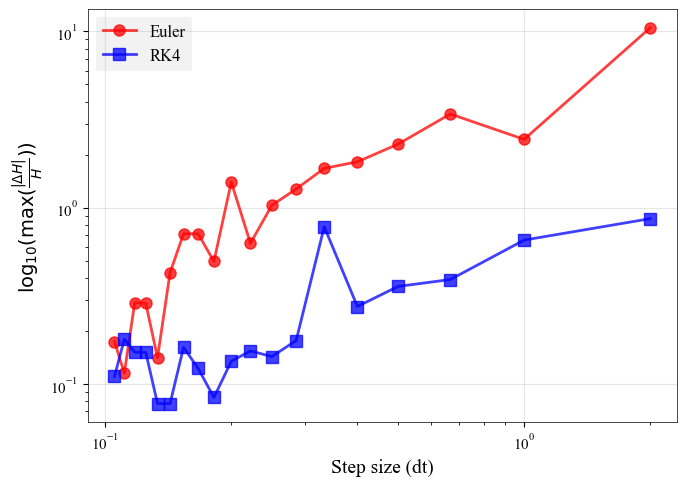

In [ ]:
# Combined comparison plot showing both coarse and fine-grained results
fig, ax2 = plt.subplots(1, 1, figsize=(7, 5))

ax2.plot([fine_results[s]['dt'] for s in fine_step_sizes], [fine_results[s]['euler']['error'] for s in fine_step_sizes], 
         'o-', label='Euler', linewidth=2, markersize=8, color='red', alpha=0.75)
ax2.plot([fine_results[s]['dt'] for s in fine_step_sizes], [fine_results[s]['rk4']['error'] for s in fine_step_sizes], 
         's-', label='RK4', linewidth=2, markersize=8, color='blue', alpha=0.75)

ax2.set_xlabel('Step size (dt)', fontsize=14)
ax2.set_ylabel('$\\text{log}_{10}(\\text{max}(\\frac{|\Delta H|}{H}))$', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
#                 textcoords='offset points', fontsize=8, alpha=0.7)
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.tight_layout()
plt.show()